In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
# TensorFlow and tf.keras
import tensorflow as tf
tf.random.set_seed(1)

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use("seaborn") # pretty matplotlib plots

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

/Users/ethanharvey/opt/anaconda3/lib/python3.8/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/ethanharvey/opt/anaconda3/lib/python3.8/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/ethanharvey/opt/anaconda3/lib/python3.8/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/ethanharvey/opt/anaconda

In [2]:
world_model_input = pd.read_csv('data/world_model_input.csv')
world_model_output = pd.read_csv('data/world_model_output.csv')

In [3]:
# One-hot encode encoded_action, encoded_orientation, encoded_shape, and color
world_model_input = world_model_input.drop('encoded_action', 1).join(pd.get_dummies(world_model_input.encoded_action, prefix='encoded_action'))
world_model_input = world_model_input.drop('encoded_orientation', 1).join(pd.get_dummies(world_model_input.encoded_orientation, prefix='encoded_orientation'))
world_model_input = world_model_input.drop('encoded_shape', 1).join(pd.get_dummies(world_model_input.encoded_shape, prefix='encoded_shape'))
world_model_input = world_model_input.drop('encoded_color', 1).join(pd.get_dummies(world_model_input.encoded_color, prefix='encoded_color'))

In [4]:
def unisonShuffleDataset(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

X = StandardScaler().fit_transform(world_model_input)
y = world_model_output.to_numpy()
X, y = unisonShuffleDataset(X, y)

In [5]:
def binary_accuracy_percision_recall(y_test, predictions):
    TP, TN, FP, FN = 0.0, 0.0, 0.0, 0.0

    for i in range(y_test.shape[0]):
        for j in range(y_test.shape[1]):
            # True positive
            if y_test[i][j] == 1 and predictions[i][j] == 1: TP = TP + 1
            # True negative
            elif y_test[i][j] == 0 and predictions[i][j] == 0: TN = TN + 1
            # False positive
            elif y_test[i][j] == 0 and predictions[i][j] == 1: FP = FP + 1
            # False negative
            elif y_test[i][j] == 1 and predictions[i][j] == 0:  FN = FN + 1
    # Calculate binary accuracy, percision, and recall            
    if (TP+TN+FP+FN != 0): acc = (TP+TN)/(TP+TN+FP+FN)
    else: acc = 0
    if (TP+FN != 0): tpr = TP/(TP+FN)
    else: tpr = 0
    if (TP+FP != 0): ppv = TP/(TP+FP)
    else: ppv = 0
    
    return acc, tpr, ppv

In [6]:
k = 5
kfold = KFold(n_splits=k)
history = []

for train_idx, test_idx in kfold.split(X):
    X_train, X_test = X[train_idx,:], X[test_idx,:]
    y_train, y_test = y[train_idx,:], y[test_idx,:]
    classifier = MultiOutputClassifier(MultinomialNB())
    classifier.fit(abs(X_train), y_train[:,0:5])
    predictions = classifier.predict(X_test)
    history.append(binary_accuracy_percision_recall(y_test[:,0:5], predictions))
    
print("Binary accuracy mean:", np.array([history[i][0] for i in range(k)]).mean(),
      "+/-", np.array([history[i][0] for i in range(k)]).std())
print("Percision mean:", np.array([history[i][1] for i in range(k)]).mean(),
      "+/-", np.array([history[i][1] for i in range(k)]).std())
print("Recall mean:", np.array([history[i][2] for i in range(k)]).mean(),
      "+/-", np.array([history[i][2] for i in range(k)]).std())

Binary accuracy mean: 0.9103448275862069 +/- 0.010280772310343843
Percision mean: 0.1303137254901961 +/- 0.04788511007165175
Recall mean: 0.21526315789473688 +/- 0.08984717368889819


In [7]:
k = 5
kfold = KFold(n_splits=k)
history = []

for train_idx, test_idx in kfold.split(X):
    X_train, X_test = X[train_idx,:], X[test_idx,:]
    y_train, y_test = y[train_idx,:], y[test_idx,:]
    classifier = MultiOutputClassifier(SVC(C=1, kernel='poly', degree=4, probability=True))
    classifier.fit(X_train, y_train[:,0:5])
    prediction = classifier.predict(X_test)
    history.append(binary_accuracy_percision_recall(y_test[:,0:5], prediction))

print("Binary accuracy mean:", np.array([history[i][0] for i in range(k)]).mean(),
      "+/-", np.array([history[i][0] for i in range(k)]).std())
print("Percision mean:", np.array([history[i][1] for i in range(k)]).mean(),
      "+/-", np.array([history[i][1] for i in range(k)]).std())
print("Recall mean:", np.array([history[i][2] for i in range(k)]).mean(),
      "+/-", np.array([history[i][2] for i in range(k)]).std())

Binary accuracy mean: 0.9402298850574713 +/- 0.004361762289887452
Percision mean: 0.3479857397504456 +/- 0.08850122155150666
Recall mean: 0.5808913308913308 +/- 0.16396914455388809


In [8]:
def init_neural_network():
    global model
    initial_learning_rate = 0.001
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=100,
        decay_rate=0.96,
        staircase=True)
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(19,)),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(5, activation='sigmoid'),
    ])
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=lr_schedule), loss='binary_crossentropy', metrics='binary_accuracy')
    return model

In [9]:
k = 5
kfold = KFold(n_splits=k)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
models = []
history = []

for train_idx, test_idx in kfold.split(X):
    X_train, X_test = X[train_idx,:], X[test_idx,:]
    y_train, y_test = y[train_idx,:], y[test_idx,:]

    model = init_neural_network()
    models.append(model.fit(X_train, y_train[:,0:5], validation_data=(X_test, y_test[:,0:5]), epochs=50, verbose=0, callbacks=[callback]))
    history.append(binary_accuracy_percision_recall(y_test[:,0:5], (model.predict(X_test) > 0.5).astype("int32")))

print("Binary accuracy mean:", np.array([history[i][0] for i in range(k)]).mean(),
      "+/-", np.array([history[i][0] for i in range(k)]).std())
print("Percision mean:", np.array([history[i][1] for i in range(k)]).mean(),
      "+/-", np.array([history[i][1] for i in range(k)]).std())
print("Recall mean:", np.array([history[i][2] for i in range(k)]).mean(),
      "+/-", np.array([history[i][2] for i in range(k)]).std())

Binary accuracy mean: 0.9466666666666667 +/- 0.008891530853247684
Percision mean: 0.34103743315508017 +/- 0.1307384053804591
Recall mean: 0.6677426438296004 +/- 0.14470179115386655


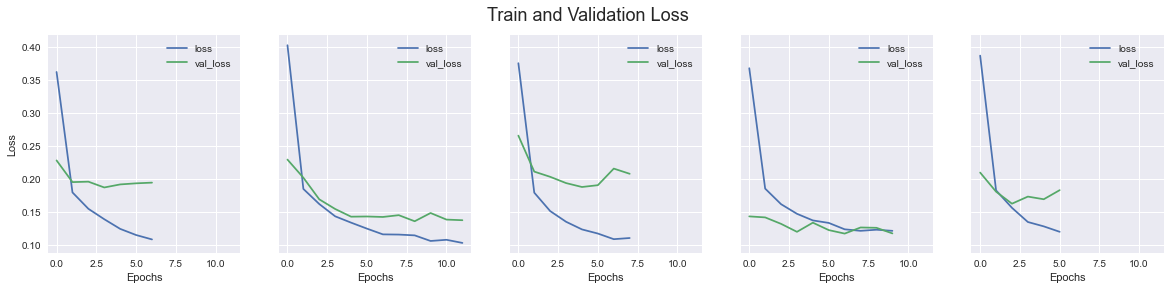

In [10]:
fig, axs = plt.subplots(1, 5, figsize=(20, 4), sharey=True, sharex=True)
for i in range(5):
    axs[i].plot(models[i].history['loss'], label='loss')
    axs[i].plot(models[i].history['val_loss'], label='val_loss')
    axs[i].legend()
    axs[i].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
fig.suptitle("Train and Validation Loss", fontsize=18)
plt.show()